In [1]:
# ## On Average Takes around 12 minutes 
import os

# !sudo apt -qq install file
# !wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fslinstaller.py
# !python2 fslinstaller.py

fslpath = "/usr/local/fsl"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, 'bin')
!. ${FSLDIR}/etc/fslconf/fsl.sh

!flirt -version 

FLIRT version 6.0


In [2]:
## Takes a bit time to read the kaggle . json file 
!pip install kaggle --upgrade
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir content/data
!kaggle datasets download -d lyfeisgood/something
!unzip /content/something.zip -d data
!pip install regtricks

In [2]:
import os
import re
import nibabel as nib
import numpy as np
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch
import regtricks
## Import my .py file ....... 
import Data_Loader as dl
import Models as model
import regtricks as rt
!pip install torchsummary
from torchsummary import summary

1.12.0+cu113
True
1.12.0+cu113
True
cuda:0
1.12.0+cu113
True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Take around 5 minutes
## Defining the path of the data 
x,y = dl.data_loader('/content/data','/content/data',device)

## Printing the shape of specifid data
print('\nShape of MRI images - >');     dl.print_data_shape(x); 
print('\nShape of ASL images - >');     dl.print_data_shape(y);

## Printing the Stats of the data
print('\nStats for MRI data(X) - >');   dl.tensor_stats(x); 
print('\nStats for ASL data(X) - >');   dl.tensor_stats(y);

## Printing the Dimension of X and Y  
## Dimension refer -> Number x Length x Breadth x Height x Channel
print('\nDimensions of X(MRI Data) ->',end=' '); dl.print_data_dimension(x)
print('\nDimensions of Y(ASL Data) ->',end=' '); dl.print_data_dimension(y)

In [ ]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, LazyConv3d , MaxPool3d, Module, Softmax, BatchNorm3d, Dropout, Conv3d, MSELoss,functional 
from torch.optim import Adam, SGD
from torchsummary import summary as tfsum 
from tqdm import tqdm
torch.cuda.empty_cache()

hidden = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (3,3,2), padding=(1,1,1)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
hidden_2 = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (3,3,5),padding=(1,1,1)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
Hidden = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (1,1,4)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
class Model_1(Module):
    '''Class for the Model to be fitted on MRI data'''
    def __init__(self, c):
        '''Intiallizing the layers of the Model'''
        super(Model_1, self).__init__();
        self.hidden1 = hidden(1,c);
        self.hidden2 = hidden(c,4*c);
        self.hidden3 = hidden(4*c,8*c);
        self.hidden4 = hidden(8*c,4*c);
        self.hidden5 = hidden(4*c, 16*c);
        self.hidden6 = hidden_2(16*c,4*c);
        self.hidden7 = Hidden(4*c,1);
    def forward(self, x):
        '''Implements the forward pass of the Network'''
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.hidden6(x)
        x = self.hidden7(x)
        return x 

In [ ]:
channels = 1; #3 Defining the number od channels we have for neural network
# Intializing model
torch.cuda.empty_cache()
model = Model_1(channels).to(device) # Intializing the model 
summary(model,(1, 91,109,91))

In [ ]:
def train(epochs,batch_size,x,y):
        '''To train the neural network and return the losses'''
        ctr = 0; train_loss = []; 
        lossFn = MSELoss(); opt = Adam(model.parameters(), lr=1e-5);
        X = x.to(device); Y = y.to(device);
        for e in tqdm(range(0, epochs)):
            model.train(); batch_loss = [];
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                opt.zero_grad();
                indices = permutation[i:i+batch_size];
                batch_x, batch_y = X[indices], Y[indices];
                pred = model(batch_x) ; loss = lossFn(pred, batch_y);
                loss.backward(); opt.step();
                batch_loss.append(loss); 
            train_loss.append(batch_loss);
            print(loss); ctr = ctr+1; 
            if ctr < epochs-1:
                del loss , pred
        return train_loss, pred;
train_loss,prediction = train(2,3,x,y);

In [ ]:
# import regtricks as rt
# str2asl_reg=rt.flirt(src=x[0],ref=y[0])
# xD=str2asl_reg.apply_to_image(x[0],ref=y[0])

In [6]:
# def data_prep(mri_data_dict,asl_data_dict,device):
#     '''
#     Params - Dictionary of MRI Data, ASL data and the device to which the tensors are stored
#     Result - Creates tensors from the data dictionary feeded
#     '''
#     x = [] ; y = []; X = []; Y = [];
#     for k,v in mri_data_dict.items():
#         if k in asl_data_dict:
#             # Loading the MRI image from the path in the train x path 
#             mri_img_x = nib.load(v); asl_img = nib.load(asl_data_dict[k]); str2asl_reg=rt.flirt(src=mri_img_x,ref=asl_img)
#             mri_img =  str2asl_reg.apply_to_image(mri_img_x,ref=asl_img)
#             # Making it a numpy array
#             mri_vec = np.array(mri_img.dataobj)[np.newaxis,:,:,:] # Channels x Length X Breadth X Slices of Brain
#             # Min max Normalizing the image 
#             mri_vec = (mri_vec - mri_vec.min()) / (mri_vec.max() - mri_vec.min())
#             # Appending the MRI image to X 
#             x.append(torch.as_tensor(mri_vec,dtype=torch.float32));#.to(device)); 
#             ## Finding the same patient with ASL data 
#             asl_img = nib.load(asl_data_dict[k]); asl_vec = np.array(asl_img.dataobj)[np.newaxis,:,:,:]; 
#             asl_vec = (asl_vec - asl_vec.min()) / (asl_vec.max() - asl_vec.min());
#             ## Appending the image to y
#             y.append(torch.as_tensor(asl_vec,dtype=torch.float32));#.to(device))
#             X = torch.stack(x,dim=0)#.to(device);
#             Y = torch.stack(y,dim=0)#.to(device);
#     return X,Y

In [47]:
# ## Takes 4 minutes
# mri,asl = dl.create_data_dict(dl.get_mri_data('/content/data'),dl.get_asl_data('/content/data'))
# x,y = data_prep(mri,asl,device)

(1, 91, 109, 91)
<class 'numpy.ndarray'>


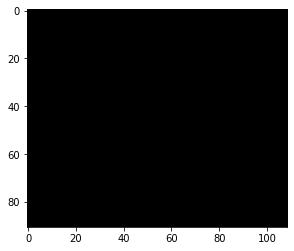

In [38]:
# # dl.print_data_dimension(x); dl.print_data_dimension(y);

# x_first = x[0]
# pred_np = x_first.cpu().detach().numpy()
# dl.print_data_dimension(pred_np); print(type(pred_np))

# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# img = [] # some array of images
# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(0,x.shape[4]):
#     ## For L2 Distance
#     frames.append([plt.imshow(pred_np[0,:,:,i], cmap=cm.Greys_r,animated=True)])
# ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)
# ani.save('movie.mp4')


In [ ]:
# from IPython.display import HTML
# from base64 import b64encode
# mp4 = open('/content/movie.mp4','rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)

In [41]:

train_loss,prediction = train(2,3,train_x,train_y);

